<a href="https://colab.research.google.com/github/BuddhikaRoshan/Deep-Learning-Assignment/blob/oshan/IT22569318.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
data_path = '/content/drive/MyDrive/Python /SE4050-DL-Lecture02-main/DL_Assignment/lung_images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


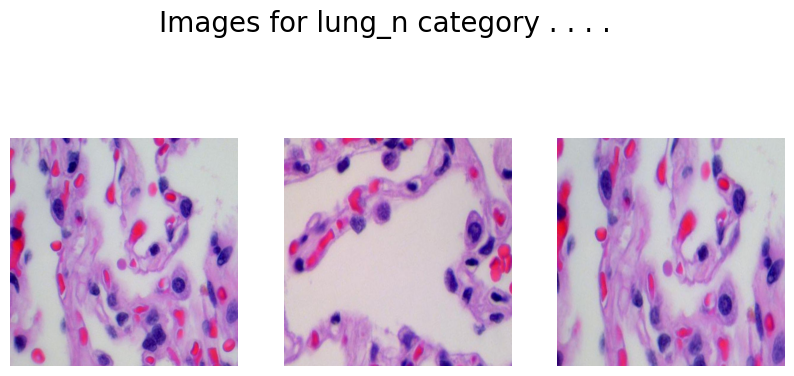

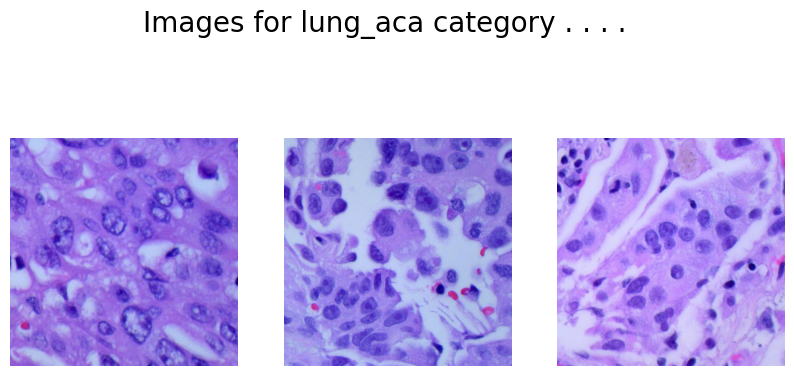

In [4]:
path = 'lung_images'
classes = ['lung_n', 'lung_aca']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [18]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 960, Validation samples: 240


In [6]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

/tmp/ipython-input-12362989.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [7]:
# Freeze base layers
base_model.trainable = False

In [8]:
# Custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
# Callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy reached 90%, stopping training.')
            self.model.stop_training = True

es = EarlyStopping(
    patience=3,
    monitor='val_accuracy',
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    verbose=1,

)

In [11]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.3556 - loss: 1.5150 - val_accuracy: 0.5042 - val_loss: 0.9392
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.4513 - loss: 1.2505 - val_accuracy: 0.5125 - val_loss: 0.8401
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4976 - loss: 1.1131 - val_accuracy: 0.5542 - val_loss: 0.7453
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5560 - loss: 0.9790 - val_accuracy: 0.5958 - val_loss: 0.6601
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.6279 - loss: 0.7716 - val_accuracy: 0.6375 - val_loss: 0.5828
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.6438 - loss: 0.7681 - val_accuracy: 0.7375 - val_loss: 0.5115
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.6740 - loss: 0.6999 - val_accuracy: 0.8083 - val_loss: 0.4493
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.7535 - loss: 0.5634 - val_accuracy: 0.8708 - val_loss

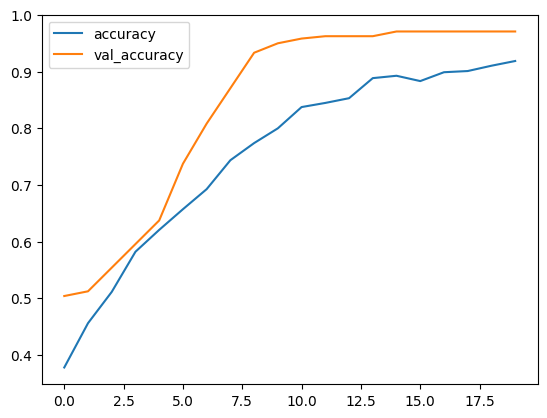

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

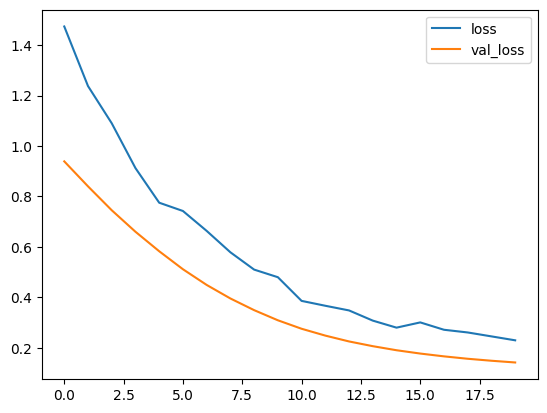

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.show()

In [19]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
              precision    recall  f1-score   support

      lung_n       1.00      0.94      0.97       120
    lung_aca       0.94      1.00      0.97       120

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



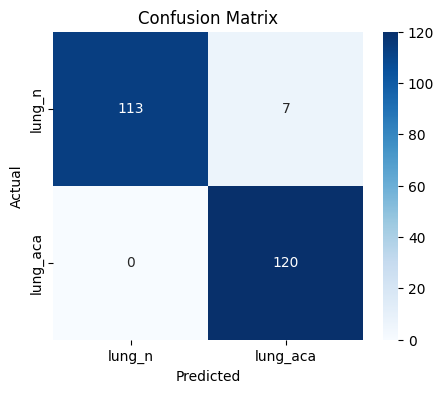

In [24]:
# -----------------------------------------------------------
# Confusion Matrix
# -----------------------------------------------------------
cm = confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()